<a href="https://colab.research.google.com/github/DiegoOCruz/Artificial-Projeto-de-bloco/blob/main/TP5_PB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production.   The filming t...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Shape da matriz TF-IDF: (50000, 2000)

Top palavras por tópico:
Tópico 1: ['young', 'like', 'good', 'great', 'character', 'life', 'movie', 'man', 'story', 'film']
Tópico 2: ['watch', 'movies', 'don', 'really', 'good', 'bad', 'just', 'like', 'film', 'movie']

Relatório de Classificação:
              precision    recall  f1-score   support

    negative       0.89      0.86      0.88      4961
    positive       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      

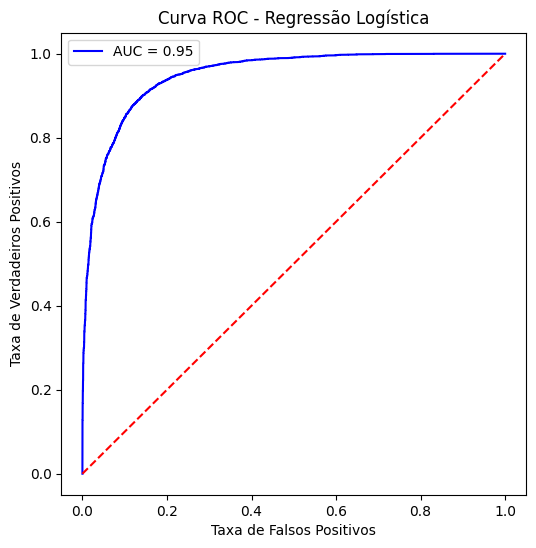

Melhores parâmetros: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Melhor score de validação cruzada: 0.8741749999999999

Relatório de Classificação (melhor modelo):
              precision    recall  f1-score   support

    negative       0.89      0.86      0.88      4961
    positive       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



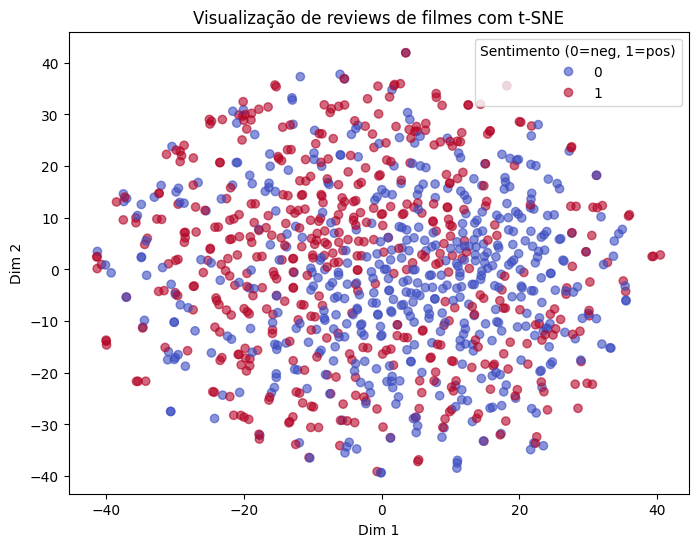

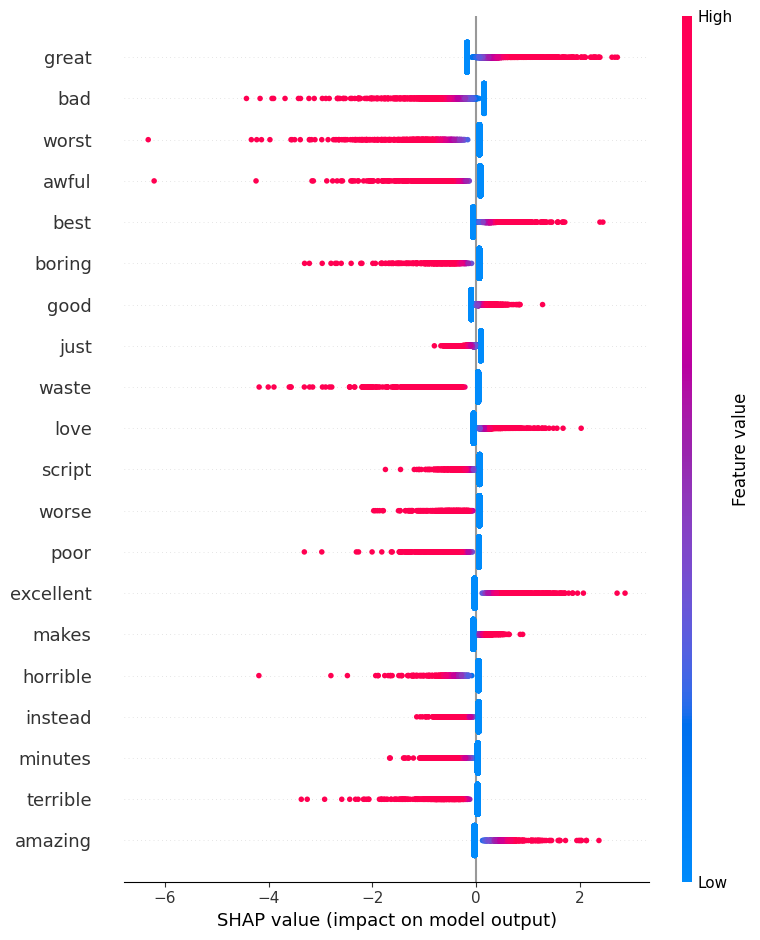

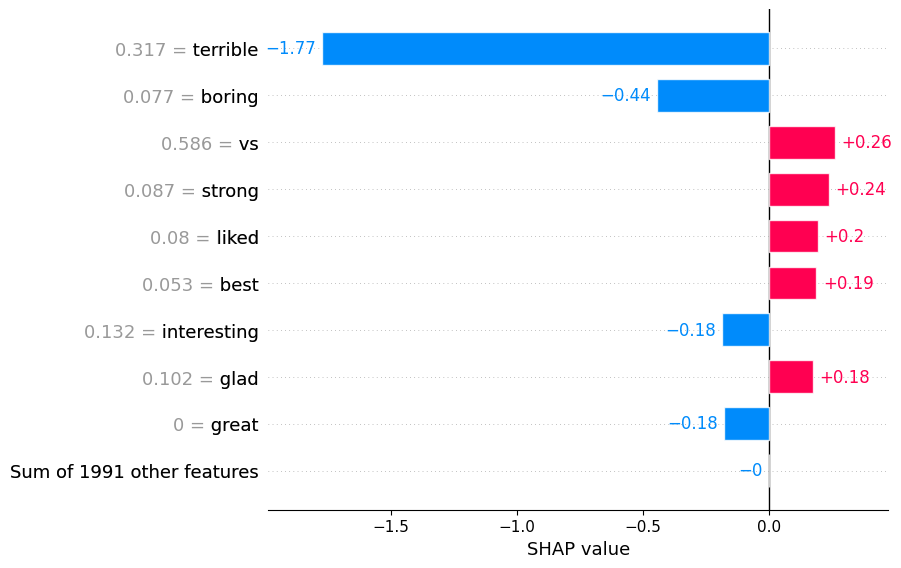


Exibindo Force-Plot para uma previsão individual:


In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import shap

# Caminho do arquivo dentro do dataset
file_path = "IMDB Dataset.csv"

# Carregar dataset
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews",
    file_path,
)

df['review'] = df['review'].str.replace('<br />', ' ', regex=False)#remover tags br

#Reduzir dimensão DF para testes
# df = df.sample(n=10_000, random_state=42)
# df = df.reset_index(drop=True)

print(df.head())

X_text = df["review"].values
y = df["sentiment"].values

# Converter sentiment para numerico
y_numerical = np.where(y == 'positive', 1, 0)


#print("X_text shape:", X_text.shape)
#print("y shape:", y.shape)

# ----------------------------
#TF-IDF
# ----------------------------
vectorizer = TfidfVectorizer(max_features=2000, stop_words="english")
X_tfidf = vectorizer.fit_transform(X_text)

print("Shape da matriz TF-IDF:", X_tfidf.shape)

# ----------------------------
#LDA (Modelagem de tópicos)
# ----------------------------
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda_topics = lda.fit_transform(X_tfidf)

print("\nTop palavras por tópico:")
for idx, topic in enumerate(lda.components_):
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    print(f"Tópico {idx+1}: {top_words}")

# ----------------------------
#CLASSIFICAÇÃO
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, zero_division=1))
print("AUC-ROC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

# Classificação usando os tópicos do LDA
X_train_topics, X_test_topics, y_train_topics, y_test_topics = train_test_split(
    lda_topics, y, test_size=0.2, random_state=42
)

clf_topics = LogisticRegression(max_iter=1000, random_state=42)
clf_topics.fit(X_train_topics, y_train_topics)
y_pred_topics = clf_topics.predict(X_test_topics)

print("\nRelatório de Classificação (usando LDA):")
print(classification_report(y_test_topics, y_pred_topics, zero_division=1))
print("AUC-ROC (usando LDA):", roc_auc_score(y_test_topics, clf_topics.predict_proba(X_test_topics)[:,1]))

# Converter y_test para numerico para roc_curve
y_test_numerical = np.where(y_test == 'positive', 1, 0)

y_pred_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_numerical, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color="red", linestyle="--")
plt.title("Curva ROC - Regressão Logística")
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.legend()
plt.show()

# Grid de parâmetros
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    #"penalty": ["l1"], teste
    "penalty": ["l2"],
    "solver": ["lbfgs", "saga"]
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor score de validação cruzada:", grid_search.best_score_)

# Avaliação final no teste
best_clf = grid_search.best_estimator_
y_pred_best = best_clf.predict(X_test)
print("\nRelatório de Classificação (melhor modelo):")
print(classification_report(y_test, y_pred_best, zero_division=1))

# ----------------------------
#VISUALIZAÇÃO COM t-SNE
# ----------------------------
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_tfidf[:1000].toarray())

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_embedded[:,0],
    X_embedded[:,1],
    c=y_numerical[:1000],
    cmap="coolwarm",
    alpha=0.6
)
plt.title("Visualização de reviews de filmes com t-SNE")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(*scatter.legend_elements(), title="Sentimento (0=neg, 1=pos)")
plt.show()

# ----------------------------
# 7. INTERPRETAÇÃO COM SHAP
# ----------------------------
explainer = shap.LinearExplainer(clf, X_train, feature_names=vectorizer.get_feature_names_out())
shap_values = explainer(X_test)

# Resumo geral: palavras mais importantes
shap.summary_plot(
    shap_values.values,
    X_test.toarray(),
    feature_names=vectorizer.get_feature_names_out()
)

# Explicação de UM review específico (exemplo: o primeiro)
shap.plots.bar(shap_values[0])

# Inicializa o Javascript do SHAP para exibição no notebook
shap.initjs()

# Gera o Force-Plot para a primeira previsão do conjunto de teste
print("\nExibindo Force-Plot para uma previsão individual:")
display(shap.force_plot(
    explainer.expected_value,
    shap_values.values[0,:],
    X_test.toarray()[0,:],
    feature_names=vectorizer.get_feature_names_out()
))